# Asian Cuisine Restaurant Business Locations Recommendation In Toronto

## Problem Statment:

## Sometimes when you would like to start a restaurant in Toronto, you have no clue where would be best locations that maximizes your chances of being successful.

## This project aims to provide insights for people who want to start up a new Asian cuisine restaurant bussiness but worried about location picking as it provides insights for them which neighborhood areas are the best candidates

---

# Data Cleaning & Visualization

In [254]:
import requests,urllib,json
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import plotly.express as px
import re
import folium
import geopy
import geopandas


latitude_toronto = 43.651070
longitude_toronto = -79.347015

## Load Toronto 2016 census dataset

In [255]:
df = pd.read_csv("neighbourhood-profiles-2016-csv.csv")
df.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


---

## Population in each neighborhood

In [256]:
df_population = df.loc[(df.Category == 'Population') & (df.Characteristic == 'Population, 2016')].iloc[:,6:].transpose().reset_index().copy()
df_population.columns = ['Neighborhood','Population']
df_population['Population'] = df_population['Population'].apply(lambda x: int(x.replace(',','')))
df_population

,Neighborhood,Population
0,Agincourt North,29113
1,Agincourt South-Malvern West,23757
2,Alderwood,12054
3,Annex,30526
4,Banbury-Don Mills,27695
...,...,...
135,Wychwood,14349
136,Yonge-Eglinton,11817
137,Yonge-St.Clair,12528
138,York University Heights,27593


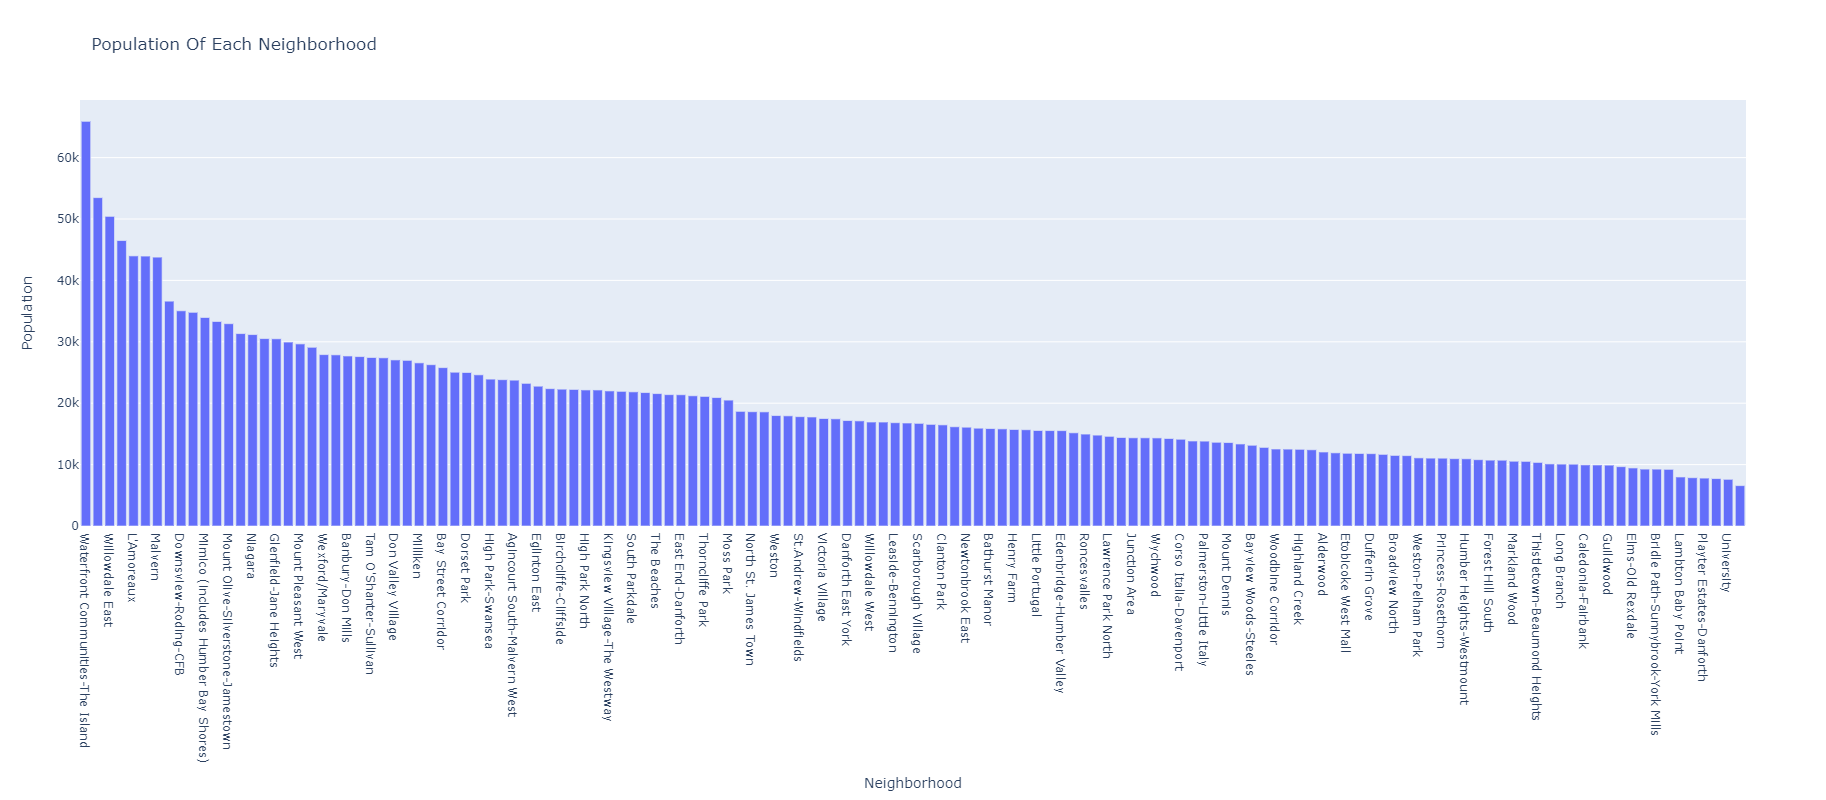

In [257]:
px.bar(df_population,x='Neighborhood',y='Population',height=800,title='Population Of Each Neighborhood').update_xaxes(categoryorder='total descending')

### Get latitudes and longitudes for Neighborhoods using geopy

In [258]:
# df_neighborhood = pd.DataFrame(df_population.Neighborhood)
# locator= geopy.Nominatim(user_agent='myGeocoder')
# latitude = []
# longitude = []
# for elem in df_neighborhood.Neighborhood:
#     try:
#         location = locator.geocode(f"{elem},Toronto")
#     except:
#         continue
#     latitude.append(location.latitude if location else np.nan)
#     longitude.append(location.longitude if location else np.nan)
# df_neighborhood['Neighborhood Latitude'] = latitude
# df_neighborhood['Neighborhood Longitude'] = longitude
# df_neighborhood.dropna(inplace=True)

In [259]:
# df_neighborhood.to_csv("Neighborhood.csv",index=False)

In [260]:
df_neighborhood = pd.read_csv("Neighborhood.csv")
df_neighborhood

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Agincourt North,43.808038,-79.266439
1,Agincourt South-Malvern West,43.789232,-79.263037
2,Alderwood,43.601717,-79.545232
3,Annex,43.670338,-79.407117
4,Banbury-Don Mills,43.734804,-79.357243
...,...,...,...
106,Wychwood,43.682122,-79.423839
107,Yonge-Eglinton,43.706748,-79.398327
108,Yonge-St.Clair,43.688019,-79.394571
109,York University Heights,43.758781,-79.519434


### Neighborhood Locations on map

In [261]:
neiborhood_map = folium.Map(location=[latitude_toronto,longitude_toronto],zoom_start=11)

for latitude,longitude,name in zip(df_neighborhood['Neighborhood Latitude'],df_neighborhood['Neighborhood Longitude'],df_neighborhood['Neighborhood']):
    label = folium.Popup(f'{name}',parse_html=True)
    folium.CircleMarker(
        [latitude,longitude],
        radius = 5,
        popup=label,
        color='#6930C3',
        fill=True,
        fill_color='#5390D9',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(neiborhood_map)
neiborhood_map

---

## Area Average Income: average individual income in each neighborhood

In [262]:
df_income = df.iloc[2272,6:].transpose().reset_index().copy()
df_income.columns = ['Neighborhood','Average Income($)']
df_income['Average Income($)'] = df_income['Average Income($)'].apply(lambda x: int(x.replace(',','')))
df_income

,Neighborhood,Average Income($)
0,Agincourt North,30414
1,Agincourt South-Malvern West,31825
2,Alderwood,47709
3,Annex,112766
4,Banbury-Don Mills,67757
...,...,...
135,Wychwood,54460
136,Yonge-Eglinton,89330
137,Yonge-St.Clair,114174
138,York University Heights,29958


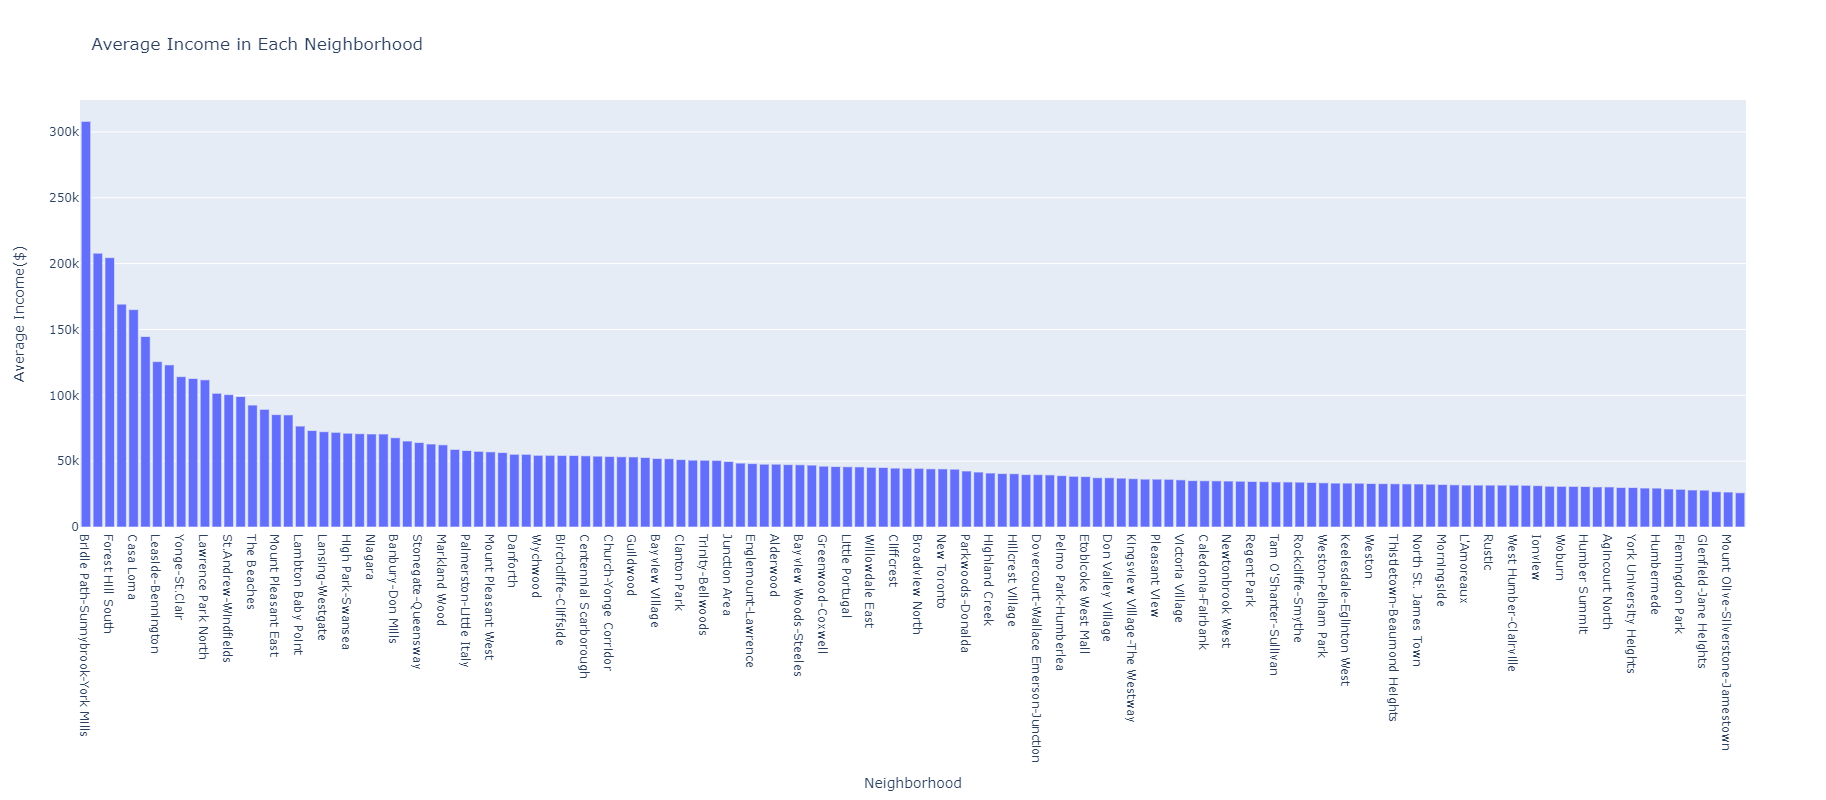

In [263]:
px.bar(data_frame=df_income,x='Neighborhood',y='Average Income($)',height=800,title='Average Income in Each Neighborhood').update_xaxes(categoryorder='total descending')

---

## Target Customer: Asian population in each neighborhood

In [264]:
visible_minority = df.iloc[1337:1349].copy()
groups = ['South Asian','Chinese','Southeast Asian','West Asian','Japanese','Korean']
visible_minority['Characteristic'] = visible_minority['Characteristic'].apply(lambda x: x.lstrip())
asian_population = visible_minority[visible_minority.Characteristic.isin(groups)].iloc[:,5:].transpose().reset_index()
asian_population.columns = ['Neighborhood'] + groups
asian_population = asian_population.set_index('Neighborhood')
asian_population[groups] = asian_population[groups].apply(lambda x: x.str.replace(',','').astype(int))
asian_population['Total Asian Population'] = asian_population[groups].sum(axis=1)
asian_population = asian_population.reset_index()
asian_population.drop(0,inplace=True)
asian_population.drop(groups,axis=1,inplace=True)

In [265]:
df_population = asian_population.merge(df_population,on='Neighborhood')
df_population['Asian Population Percentage'] = df_population['Total Asian Population'] / df_population['Population']
df_population

,Neighborhood,Total Asian Population,Population,Asian Population Percentage
0,Agincourt North,22290,29113,0.765637
1,Agincourt South-Malvern West,16010,23757,0.673907
2,Alderwood,990,12054,0.082130
3,Annex,4660,30526,0.152657
4,Banbury-Don Mills,9090,27695,0.328218
...,...,...,...,...
135,Wychwood,1475,14349,0.102795
136,Yonge-Eglinton,2080,11817,0.176018
137,Yonge-St.Clair,1625,12528,0.129709
138,York University Heights,8080,27593,0.292828


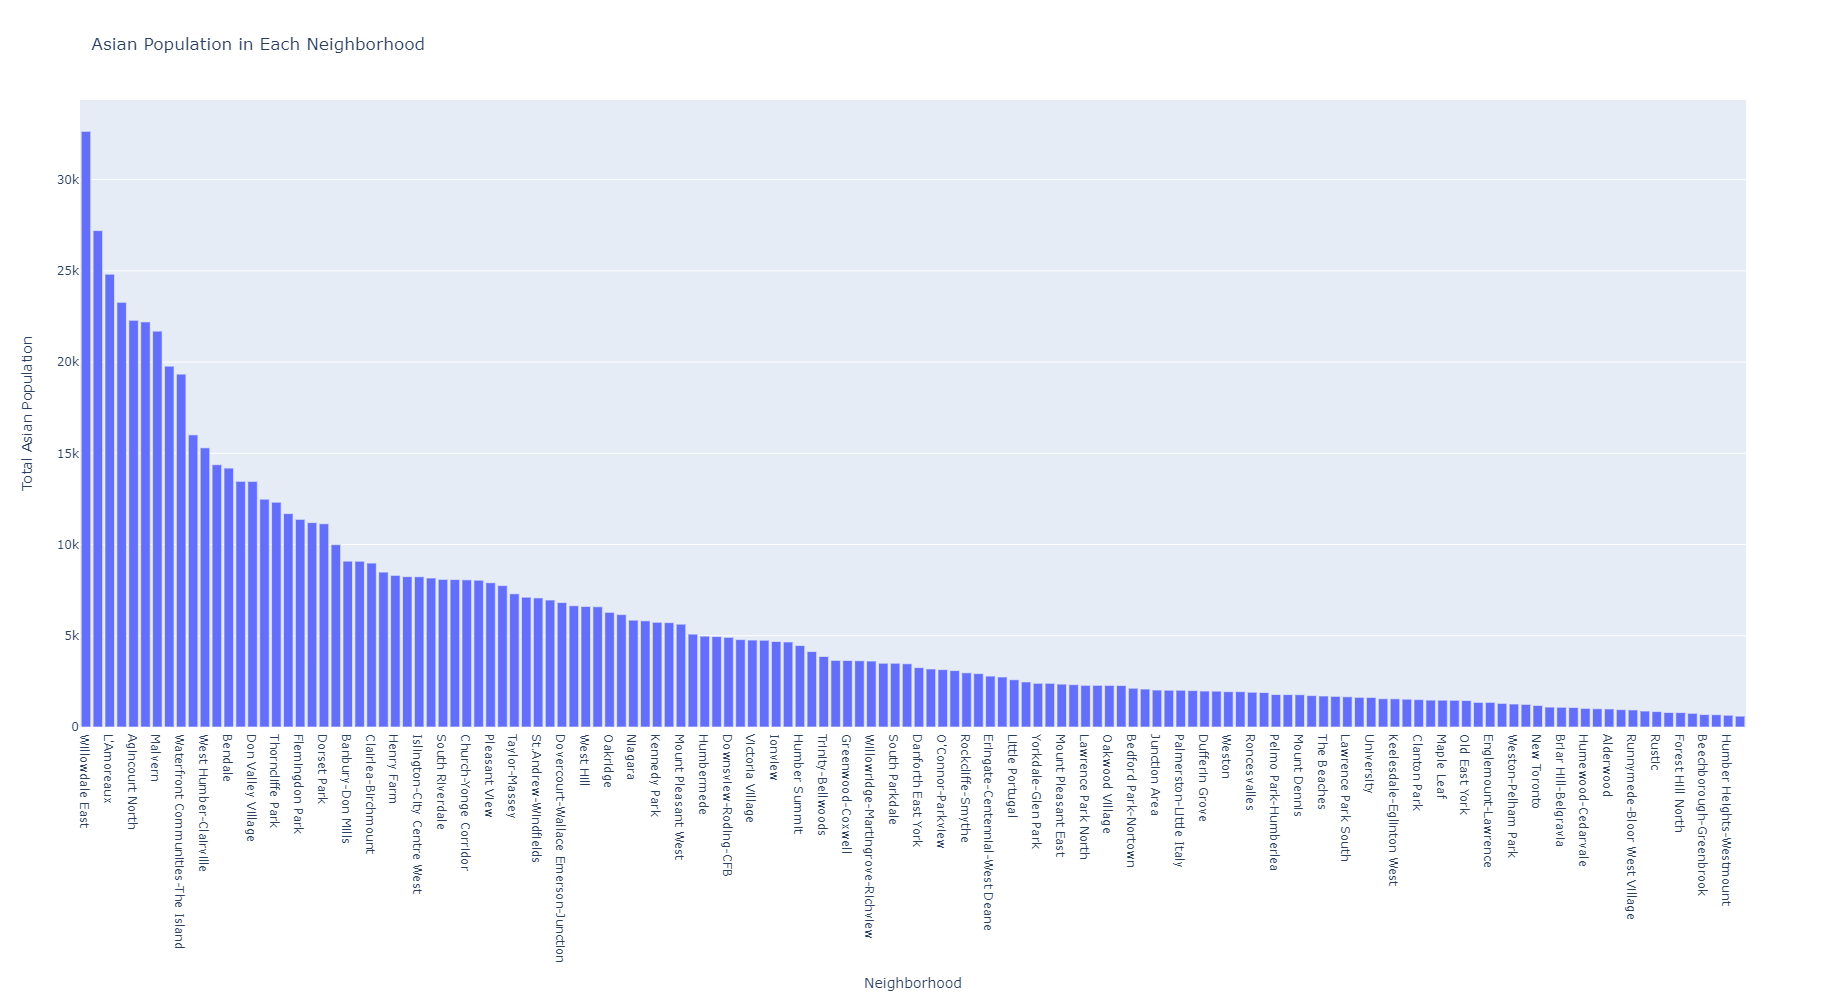

In [266]:
px.bar(data_frame=asian_population,x='Neighborhood',y='Total Asian Population',height=1000,title='Asian Population in Each Neighborhood').update_xaxes(categoryorder='total descending')

---

## Safety: robbery data from public safety data portal

In [267]:
robbery_crime = pd.read_csv("Robbery_2014_to_2019.csv")
robbery_crime = robbery_crime[robbery_crime.reportedyear == 2019]
robbery_crime.Neighbourhood = robbery_crime.Neighbourhood.apply(lambda x: re.search(r'[a-zA-Z -]+',x)[0].rstrip())
robbery_crime.head()

,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId
14020,131641,GO-2019378335,1551396240000,1551396240000,Outside,1610,220,Robbery - Other,2019,February,...,59.0,Thursday,23,Robbery,D12,23,Pelmo Park-Humberlea,-79.531509,43.714092,14021
14111,131648,GO-20191159058,1561220100000,1561220400000,Apartment,1610,140,Robbery - Vehicle Jacking,2019,June,...,173.0,Saturday,16,Robbery,D22,9,Edenbridge-Humber Valley,-79.511459,43.683964,14112
14120,131649,GO-20191161065,1561239000000,1561242960000,Outside,1610,100,Robbery With Weapon,2019,June,...,173.0,Saturday,21,Robbery,D42,132,Malvern,-79.228691,43.809391,14121
14122,131671,GO-20191367190,1563682800000,1563696000000,Commercial,1610,210,Robbery - Business,2019,July,...,202.0,Sunday,4,Robbery,D12,23,Pelmo Park-Humberlea,-79.507225,43.715458,14123
14123,131673,GO-2019173909,1548675240000,1548675600000,Other,1610,210,Robbery - Business,2019,January,...,28.0,Monday,11,Robbery,D31,22,Humbermede,-79.542130,43.750851,14124


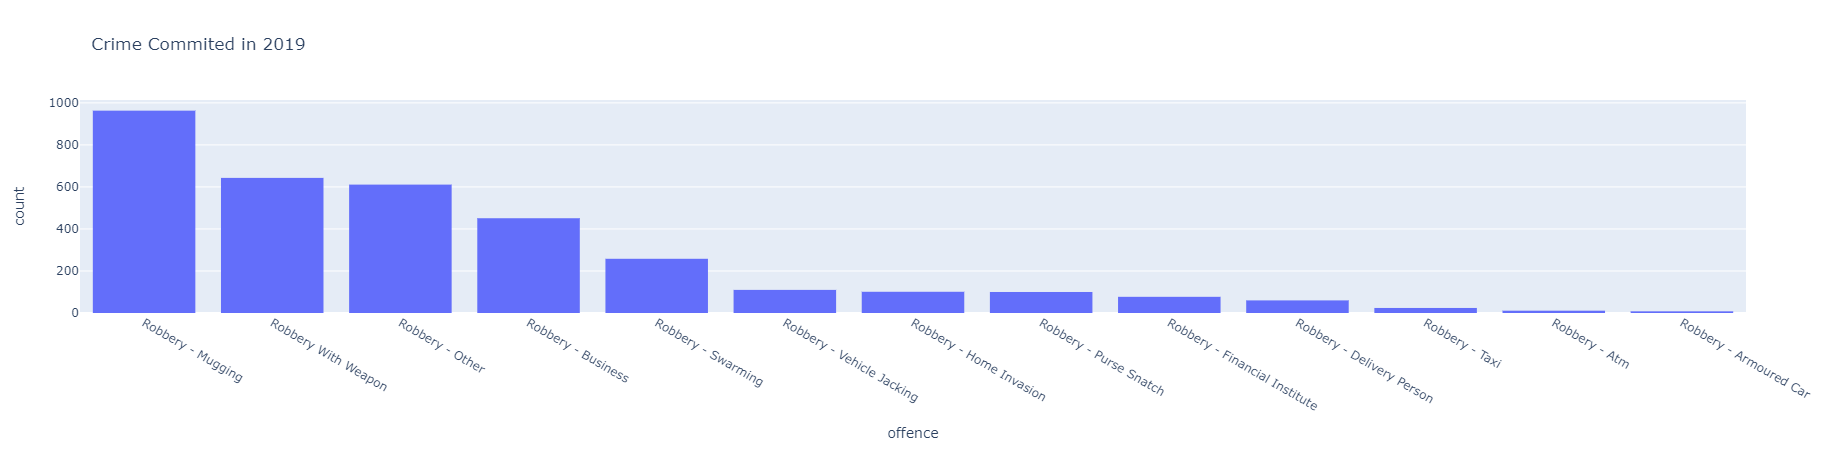

In [268]:
px.histogram(data_frame=robbery_crime,x='offence',title='Crime Commited in 2019').update_xaxes(categoryorder='total descending')

In [269]:
df_safety = robbery_crime.Neighbourhood.value_counts().reset_index()
df_safety.columns=['Neighborhood','Crime Cases']
df_safety

,Neighborhood,Crime Cases
0,Church-Yonge Corridor,143
1,Moss Park,137
2,Bay Street Corridor,123
3,Waterfront Communities-The Island,95
4,York University Heights,79
...,...,...
135,Woodbine-Lumsden,3
136,Rustic,3
137,Humber Heights-Westmount,2
138,Leaside-Bennington,2


---

### Get nearby venues for each neighborhood (limit to 50 venues per area in the return list)

#### Since I got the query result previously,I will comment below cell and load the data directly from the saved csv file to save time

In [270]:
# client_id = "WGENET1SWCZBUQYDFZDF5DGW5AIIE1THJCXUCQ1DW4PTHJNH"
# client_secret = "CHCVAO54RWBGKU0IXZGZMVZCEG4DBCAPLOGNEWQNNW3V2MQJ"
# version = "20180605"

In [271]:
# def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
#     venues_list=[]
#     for name, lat, lng in zip(names, latitudes, longitudes):           
#         # create the API request URL
#         url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
#             client_id, 
#             client_secret, 
#             version, 
#             lat, 
#             lng, 
#             'Asian Restaurant',
#             radius, 
#             100)
            
#         # make the GET request
#         results = requests.get(url).json()["response"]['groups'][0]['items']
        
#         # return only relevant information for each nearby venue
#         venues_list.append([(
#             name, 
#             lat, 
#             lng, 
#             v['venue']['name'], 
#             v['venue']['location']['lat'], 
#             v['venue']['location']['lng'],  
#             v['venue']['categories'][0]['name']) for v in results])

#     nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
#     nearby_venues.columns = ['Neighborhood', 
#                   'Neighborhood Latitude', 
#                   'Neighborhood Longitude', 
#                   'Venue', 
#                   'Venue Latitude', 
#                   'Venue Longitude', 
#                   'Venue Category']
    
#     return(nearby_venues)

In [272]:
# venues = getNearbyVenues(names=df_restaruants['Neighborhood'],latitudes=df_restaruants['Neighborhood Latitude'],longitudes=df_restaruants['Neighborhood Longitude'])

In [273]:
# venues.to_csv('Asian_Restaurants.csv',index=False)

### Venue list overview

In [274]:
venues = pd.read_csv("Asian_Restaurants.csv")
venues.head()
# for feature in ['Venue Latitude','Venue Longitude']:
#     venues = venues[venues[feature] != np.NaN]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt North,43.808038,-79.266439,Saravanaa Bhavan South Indian Restaurant,43.810117,-79.269275,Indian Restaurant
1,Agincourt North,43.808038,-79.266439,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant
2,Agincourt North,43.808038,-79.266439,Xe Lua Vietnamese Cuisine 火車頭,43.809224,-79.269547,Vietnamese Restaurant
3,Agincourt North,43.808038,-79.266439,Casa Deluz 豪門宴,43.808955,-79.268113,Dim Sum Restaurant
4,Agincourt North,43.808038,-79.266439,Bento Box,43.809248,-79.269029,Japanese Restaurant


### Restuarant locations on map

In [275]:
venue_map = folium.Map(location=[latitude_toronto,longitude_toronto],zoom_start=11)

for latitude,longitude,name,category in zip(venues['Venue Latitude'],venues['Venue Longitude'],venues['Venue'],venues['Venue Category']):
    label = folium.Popup(f'{name},{category}',parse_html=True)
    folium.CircleMarker(
        [latitude,longitude],
        radius = 5,
        popup=label,
        color='#6930C3',
        fill=True,
        fill_color='#5390D9',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(venue_map)
venue_map

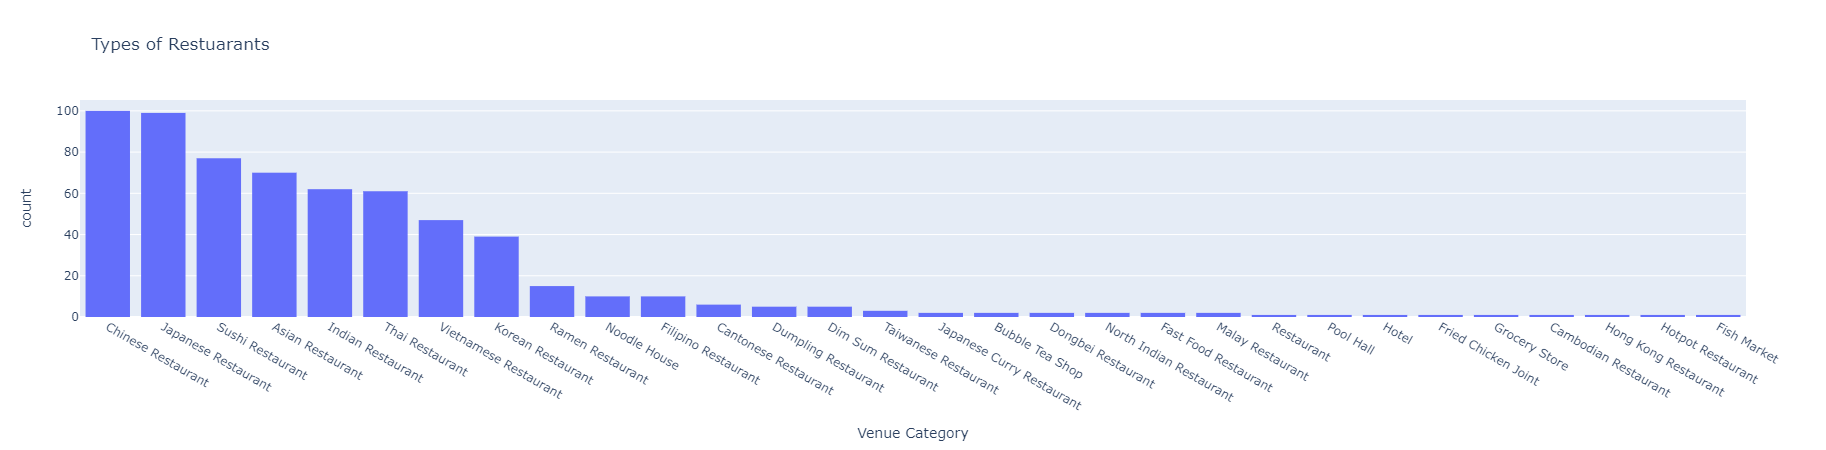

In [276]:
px.histogram(data_frame=venues,x='Venue Category',title='Types of Restuarants').update_xaxes(categoryorder = 'total descending')

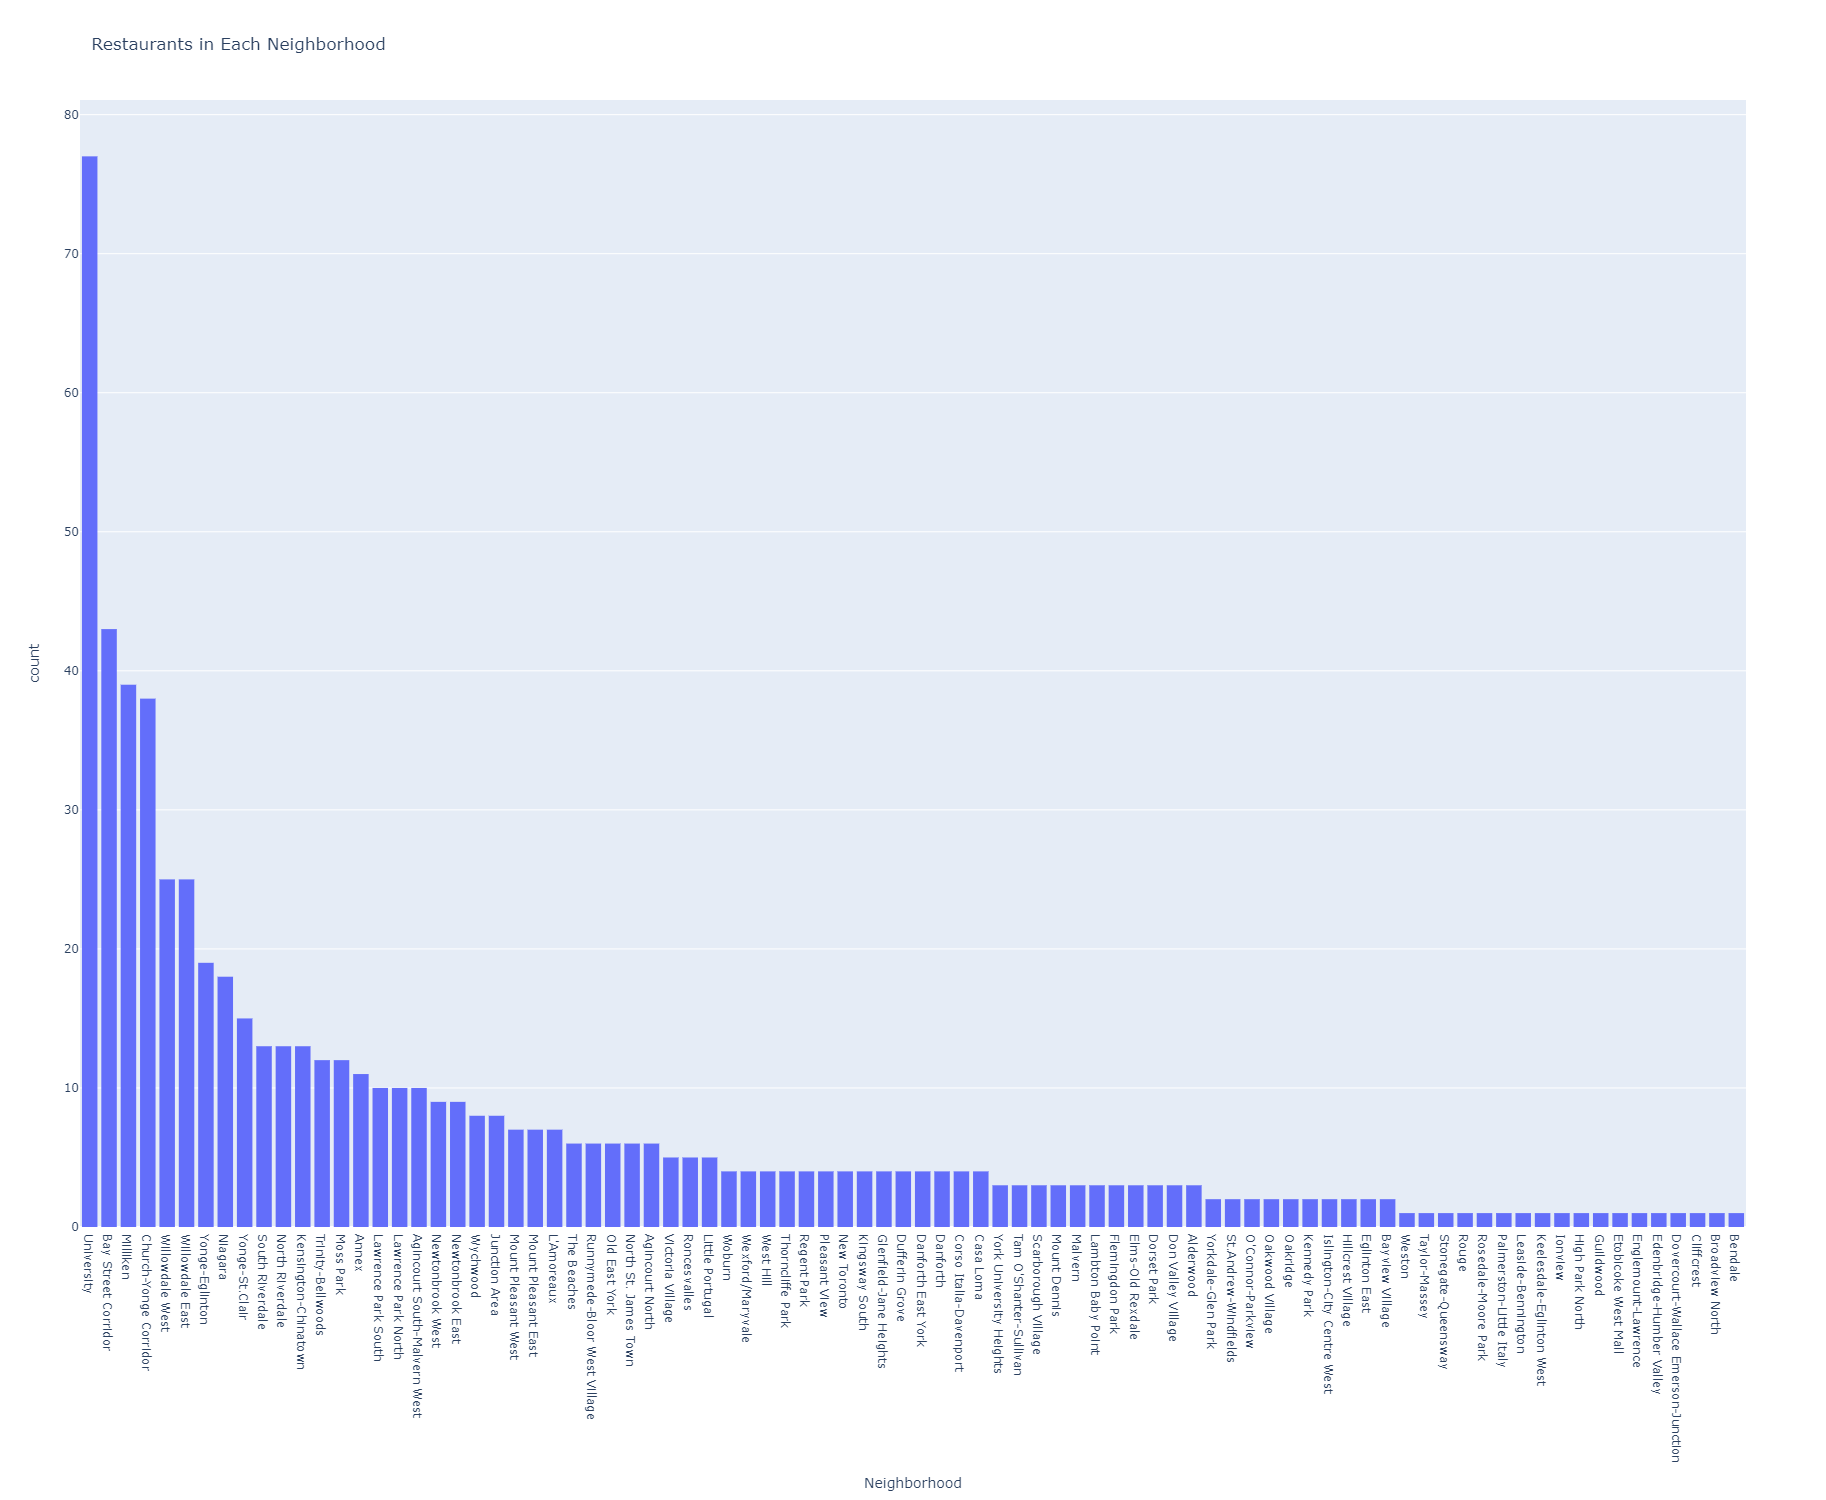

In [277]:
px.histogram(data_frame=venues,x='Neighborhood',height=1500,title='Restaurants in Each Neighborhood').update_xaxes(categoryorder= 'total descending')

In [278]:
df_restaruants = venues.Neighborhood.value_counts().reset_index().copy()
df_restaruants.columns = ['Neighborhood','Restaurants']
df_restaruants = df_neighborhood.merge(df_restaruants,on='Neighborhood')
df_restaruants.Neighborhood = df_restaruants.Neighborhood.apply(lambda x: x.lstrip().rstrip())
df_restaruants.dropna(inplace=True)
df_restaruants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurants
0,Agincourt North,43.808038,-79.266439,6
1,Agincourt South-Malvern West,43.789232,-79.263037,10
2,Alderwood,43.601717,-79.545232,3
3,Annex,43.670338,-79.407117,11
4,Bay Street Corridor,43.664457,-79.387189,43
...,...,...,...,...
81,Wychwood,43.682122,-79.423839,8
82,Yonge-Eglinton,43.706748,-79.398327,19
83,Yonge-St.Clair,43.688019,-79.394571,15
84,York University Heights,43.758781,-79.519434,3


---

## Combine all sub dataframes

In [279]:
df_final = df_income.merge(df_population,on='Neighborhood')
df_final = df_final.merge(df_safety,on='Neighborhood')
df_final = df_restaruants.merge(df_final,on='Neighborhood')
df_final.drop(['Total Asian Population','Population'],axis=1,inplace=True)
df_final.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurants,Average Income($),Asian Population Percentage,Crime Cases
0,Agincourt North,43.808038,-79.266439,6,30414,0.765637,35
1,Agincourt South-Malvern West,43.789232,-79.263037,10,31825,0.673907,29
2,Alderwood,43.601717,-79.545232,3,47709,0.082130,5
3,Annex,43.670338,-79.407117,11,112766,0.152657,31
4,Bay Street Corridor,43.664457,-79.387189,43,56526,0.483971,123


# K-means Clustering

## Normalizes data

In [280]:
from sklearn.preprocessing import StandardScaler

df_kmeans = df_final.iloc[:,-4:]
df_kmeans = StandardScaler().fit_transform(df_kmeans)
df_kmeans[:5]

array([[-0.12890733, -0.71894825,  2.56665171,  0.30135888],
       [ 0.21925263, -0.67786793,  2.08418091,  0.0720746 ],
       [-0.3900273 , -0.21541585, -1.02835099, -0.84506255],
       [ 0.30629262,  1.67867536, -0.6574076 ,  0.14850269],
       [ 3.09157231,  0.04128523,  1.08518721,  3.66419509]])

## Finding optimal number of clusters

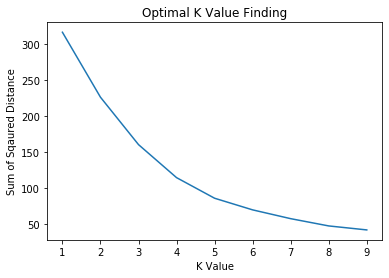

In [281]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k = range(1,10)
distance = []

for i in k:
    clusters = KMeans(n_clusters=i).fit(df_kmeans)
    distance.append(clusters.inertia_)

plt.figure()
plt.plot(k,distance)
plt.xlabel('K Value')
plt.ylabel('Sum of Sqaured Distance')
plt.title('Optimal K Value Finding')
plt.show()

- `4` clusters would be a relative good choice

In [288]:
k=4
model = KMeans(k).fit(df_kmeans)
df_final_with_cluster = df_final.copy()
df_final_with_cluster['Clusters'] = model.labels_
df_final_with_cluster.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurants,Average Income($),Asian Population Percentage,Crime Cases,Clusters
0,Agincourt North,43.808038,-79.266439,6,30414,0.765637,35,1
1,Agincourt South-Malvern West,43.789232,-79.263037,10,31825,0.673907,29,1
2,Alderwood,43.601717,-79.545232,3,47709,0.082130,5,0
3,Annex,43.670338,-79.407117,11,112766,0.152657,31,2
4,Bay Street Corridor,43.664457,-79.387189,43,56526,0.483971,123,3


## Visualize neighborhoods in each cluster

In [283]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final_with_cluster['Neighborhood Latitude'], df_final_with_cluster['Neighborhood Longitude'], df_final_with_cluster['Neighborhood'], df_final_with_cluster['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [284]:
df_final_with_cluster[df_final_with_cluster.Clusters == 0]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurants,Average Income($),Asian Population Percentage,Crime Cases,Clusters
2,Alderwood,43.601717,-79.545232,3,47709,0.082130,5,0
7,Broadview North,43.683924,-79.356964,1,44557,0.127402,10,0
10,Cliffcrest,43.721939,-79.236232,1,44718,0.259492,25,0
11,Corso Italia-Davenport,43.677954,-79.443083,4,41717,0.075709,28,0
12,Danforth,43.686433,-79.300356,4,55225,0.183633,18,0
13,Danforth East York,43.686433,-79.300356,4,51846,0.189464,6,0
16,Dovercourt-Wallace Emerson-Junction,43.662394,-79.446519,1,39740,0.186212,47,0
17,Dufferin Grove,43.653632,-79.426439,4,40588,0.167162,32,0
20,Elms-Old Rexdale,43.710814,-79.565390,3,32012,0.181895,14,0
21,Englemount-Lawrence,43.714242,-79.437072,1,48134,0.060343,16,0


- Low `Competition`
- Middle `Area Average Income`
- Low `Target Customers`
- Middle `Safety`

In [285]:
df_final_with_cluster[df_final_with_cluster.Clusters == 1]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurants,Average Income($),Asian Population Percentage,Crime Cases,Clusters
3,Annex,43.670338,-79.407117,11,112766,0.152657,31,1
8,Casa Loma,43.678102,-79.409416,4,165047,0.099380,8,1
18,Edenbridge-Humber Valley,43.672223,-79.514685,1,101551,0.079820,5,1
34,Kingsway South,43.647381,-79.511333,4,144642,0.080897,12,1
36,Lawrence Park North,43.729199,-79.403253,10,111730,0.156432,5,1
37,Lawrence Park South,43.729199,-79.403253,10,169203,0.109032,13,1
38,Leaside-Bennington,43.702225,-79.358012,1,125564,0.118552,2,1
58,Rosedale-Moore Park,43.690388,-79.383297,1,207903,0.118052,19,1


- Low `Competition`
- High `Area Average Income`
- Low `Target Customers`
- High `Safety`

In [286]:
df_final_with_cluster[df_final_with_cluster.Clusters == 2]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurants,Average Income($),Asian Population Percentage,Crime Cases,Clusters
0,Agincourt North,43.808038,-79.266439,6,30414,0.765637,35,2
1,Agincourt South-Malvern West,43.789232,-79.263037,10,31825,0.673907,29,2
5,Bayview Village,43.769197,-79.376662,2,52035,0.546597,14,2
6,Bendale,43.753520,-79.255336,1,33256,0.473632,40,2
14,Don Valley Village,43.792673,-79.354722,3,37379,0.497579,34,2
15,Dorset Park,43.752847,-79.282067,3,31692,0.445547,35,2
19,Eglinton East,43.739465,-79.232100,2,30033,0.361784,27,2
23,Flemingdon Park,43.718432,-79.333204,3,28654,0.518853,13,2
27,Hillcrest Village,43.799664,-79.365019,2,40442,0.661391,16,2
33,Kensington-Chinatown,43.653567,-79.405496,13,37422,0.455001,46,2


- Middle `Competition`
- Low `Area Average Income`
- High `Target Customers`
- Middle `Safety`

In [287]:
df_final_with_cluster[df_final_with_cluster.Clusters == 3]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurants,Average Income($),Asian Population Percentage,Crime Cases,Clusters
4,Bay Street Corridor,43.664457,-79.387189,43,56526,0.483971,123,3
9,Church-Yonge Corridor,43.662844,-79.386311,38,53583,0.257339,143,3
42,Moss Park,43.654644,-79.369728,12,58915,0.177997,137,3
68,University,43.656119,-79.384670,77,50757,0.212962,12,3


- High `Competition`
- Middle `Area Average Income`
- Low `Target Customers`
- Low `Safety`